In [2]:
# initializing packages
import numpy as np
import pandas as pd
from scipy.io import loadmat
import glob
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from scipy import stats
from mne.viz import circular_layout, plot_connectivity_circle
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
import pyreadstat

import scipy.stats as chi2_contingency
import scipy.stats as stats
from scipy.spatial import distance

# increasing display number of pandas columns and rows
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [3]:
# functions to transform vector to dfnc matrix
def calc_num_components(a):
    num_pairs = len(a)
    num_components = int(np.ceil(np.sqrt(2 * num_pairs - 1)))
    if num_components * (num_components - 1) == 2 * num_pairs:
        return num_components
    else:
        return 0


def return_dfnc_from_vector(a):
    '''This Function returns a dfnc matrix given a vector
        a : the vector of correlation pairs
    '''
    n = calc_num_components(a)
    out = np.zeros((n, n))

    if not n:
        return out
    
    l_indices = np.tril_indices(n, -1)
    u_indices = np.triu_indices(n, 1)

    out[u_indices] = a
    out[l_indices] = out.T[l_indices]
    
    return out

In [4]:
# variables used throughout the script
n_subjects = 48
n_controls = 17
n_controls_1 = 16 # as python starts indexing with zero
n_patients = 31

# Number of dFNC windows, number of correlations
n_windows = 159
n_corr = 78

In [5]:
# index of subgroups: worse == ARAT < 29; better == ARAT > 28 
worse= [34, 28, 19, 33, 42, 37, 25, 29, 27, 45, 46, 17, 31] 
better = [36, 38,35, 40, 41, 43,  39,  32, 18, 30, 26, 24, 23, 22, 21, 20, 44, 47] 

In [6]:
# correct indexing when having behavior of stroke patients only (excluding 17 controls)
worse_zero = np.subtract(worse,17)
better_zero = np.subtract(better,17)

# array indicating worse or better functional status
subgroups = np.ones(31)
subgroups[worse_zero] = 2

In [7]:
# Load clinical variables of stroke patients
DFNC_clinical = pd.read_csv("DFNC_clinical.csv")

In [9]:
print("Mean Days since stroke: %f" %DFNC_clinical["Days_since_stroke"].mean())
print("STD Days since stroke: %f" %DFNC_clinical["Days_since_stroke"].std())

Mean Days since stroke: 7.161290
STD Days since stroke: 3.578610


In [10]:
# Moderately affected
print("Mean Lesion Volume: %f" %DFNC_clinical.iloc[better_zero]["Lesion_vol"].mean())
print("Mean CST Tract overlay: %f" %DFNC_clinical.iloc[better_zero]["Percent_CST"].mean())
print("Median Lesion Volume: %f" %DFNC_clinical.iloc[better_zero]["Lesion_vol"].median())
print("Median CST Tract overlay: %f" %DFNC_clinical.iloc[better_zero]["Percent_CST"].median())
print("Mean ARAT: %f" %DFNC_clinical.iloc[better_zero]["ARAT"].mean())
print("Mean Grip rel: %f" %DFNC_clinical.iloc[better_zero]["Grip_rel"].mean())
print("Mean JTT: %f" %DFNC_clinical.iloc[better_zero]["JTT_aff"].mean())
print("Mean Days since stroke: %f" %DFNC_clinical.iloc[better_zero]["Days_since_stroke"].mean())
print("Mean std Lesion Volume: %f" %DFNC_clinical.iloc[better_zero]["Lesion_vol"].std())
print("Mean std CST Tract overlay: %f" %DFNC_clinical.iloc[better_zero]["Percent_CST"].std())
print("Median std Lesion Volume: %f" %DFNC_clinical.iloc[better_zero]["Lesion_vol"].std())
print("Median std CST Tract overlay: %f" %DFNC_clinical.iloc[better_zero]["Percent_CST"].std())
print("Mean std ARAT: %f" %DFNC_clinical.iloc[better_zero]["ARAT"].std())
print("Mean std Grip rel: %f" %DFNC_clinical.iloc[better_zero]["Grip_rel"].std())
print("Mean std JTT: %f" %DFNC_clinical.iloc[better_zero]["JTT_aff"].std())
print("Mean std Days since stroke: %f" %DFNC_clinical.iloc[better_zero]["Days_since_stroke"].std())

Mean Lesion Volume: 29263.111111
Mean CST Tract overlay: 0.087346
Median Lesion Volume: 12732.000000
Median CST Tract overlay: 0.044890
Mean ARAT: 44.529412
Mean Grip rel: 0.571550
Mean JTT: 154.357647
Mean Days since stroke: 6.166667
Mean std Lesion Volume: 38756.727442
Mean std CST Tract overlay: 0.142502
Median std Lesion Volume: 38756.727442
Median std CST Tract overlay: 0.142502
Mean std ARAT: 9.887604
Mean std Grip rel: 0.231180
Mean std JTT: 104.493047
Mean std Days since stroke: 2.662374


In [11]:
# Severely affected
print("Mean Lesion Volume: %f" %DFNC_clinical.iloc[worse_zero]["Lesion_vol"].mean())
print("Mean CST Tract overlay: %f" %DFNC_clinical.iloc[worse_zero]["Percent_CST"].mean())
print("Median Lesion Volume: %f" %DFNC_clinical.iloc[worse_zero]["Lesion_vol"].median())
print("Median CST Tract overlay: %f" %DFNC_clinical.iloc[worse_zero]["Percent_CST"].median())
print("Mean ARAT: %f" %DFNC_clinical.iloc[worse_zero]["ARAT"].mean())
print("Mean Grip rel: %f" %DFNC_clinical.iloc[worse_zero]["Grip_rel"].mean())
print("Mean JTT: %f" %DFNC_clinical.iloc[worse_zero]["JTT_aff"].mean())
print("Mean Days since stroke: %f" %DFNC_clinical.iloc[worse_zero]["Days_since_stroke"].mean())

Mean Lesion Volume: 22804.923077
Mean CST Tract overlay: 0.105654
Median Lesion Volume: 12960.000000
Median CST Tract overlay: 0.091658
Mean ARAT: 10.000000
Mean Grip rel: 0.156335
Mean JTT: 692.397500
Mean Days since stroke: 8.538462


In [12]:
# Corresponding t-tests between subgroups
print("T-test Lesion volume: %f" %stats.ttest_ind(DFNC_clinical.iloc[better_zero]["Lesion_vol"], DFNC_clinical.iloc[worse_zero]["Lesion_vol"])[1])
print("T-test CST Tract overlay: %f" %stats.ttest_ind(DFNC_clinical.iloc[better_zero]["Percent_CST"], DFNC_clinical.iloc[worse_zero]["Percent_CST"])[1])
print("T-test ARAT: %f" %stats.ttest_ind(DFNC_clinical.iloc[better_zero]["ARAT"].dropna(), DFNC_clinical.iloc[worse_zero]["ARAT"].dropna())[1])
print("T-test Grip rel: %f" %stats.ttest_ind(DFNC_clinical.iloc[better_zero]["Grip_rel"].dropna(), DFNC_clinical.iloc[worse_zero]["Grip_rel"].dropna())[1])
print("T-test JTT: %f" %stats.ttest_ind(DFNC_clinical.iloc[better_zero]["JTT_aff"].dropna(), DFNC_clinical.iloc[worse_zero]["JTT_aff"].dropna())[1])
print("T-test Days since stroke: %f" %stats.ttest_ind(DFNC_clinical.iloc[better_zero]["Days_since_stroke"], DFNC_clinical.iloc[worse_zero]["Days_since_stroke"])[1])



T-test Lesion volume: 0.615520
T-test CST Tract overlay: 0.682064
T-test ARAT: 0.000000
T-test Grip rel: 0.000012
T-test JTT: 0.000000
T-test Days since stroke: 0.067652


In [13]:
# load subject names
subject_names = glob.glob('/Users/anna/Documents/LV_Stroke_new/Data/DFNC_LV_no15_0307/WithSM_dfnc_sub*',)
subject_names = sorted(subject_names)

In [14]:
# load individual fncs
dfnc = np.zeros((n_subjects,n_windows,n_corr))
for n in range(0,n_subjects,1):
    
    dfnc[n] = loadmat(subject_names[n][-40:])['FNCdyn']

In [15]:
np.shape(dfnc)

(48, 159, 78)

In [16]:
# load state information per window (before: saving clusterInfo.states as variable "a" in matlab ("WithSM_dfnc_post_process"))
x = loadmat('states_stroke.mat')["a"]
for n in range(0,np.shape(x)[0],1):
    if n==0:
        states = pd.DataFrame(x[n][0])
    else:
        states[n] = pd.DataFrame(x[n][0])
states = states.transpose()

In [17]:
# load individual fraction times
fraction = loadmat('fraction_time.mat')["frac"]
fraction = pd.DataFrame(fraction)
fraction.columns = ["State_1", "State_2", "State_3"]

Subgroup analysis 

[]

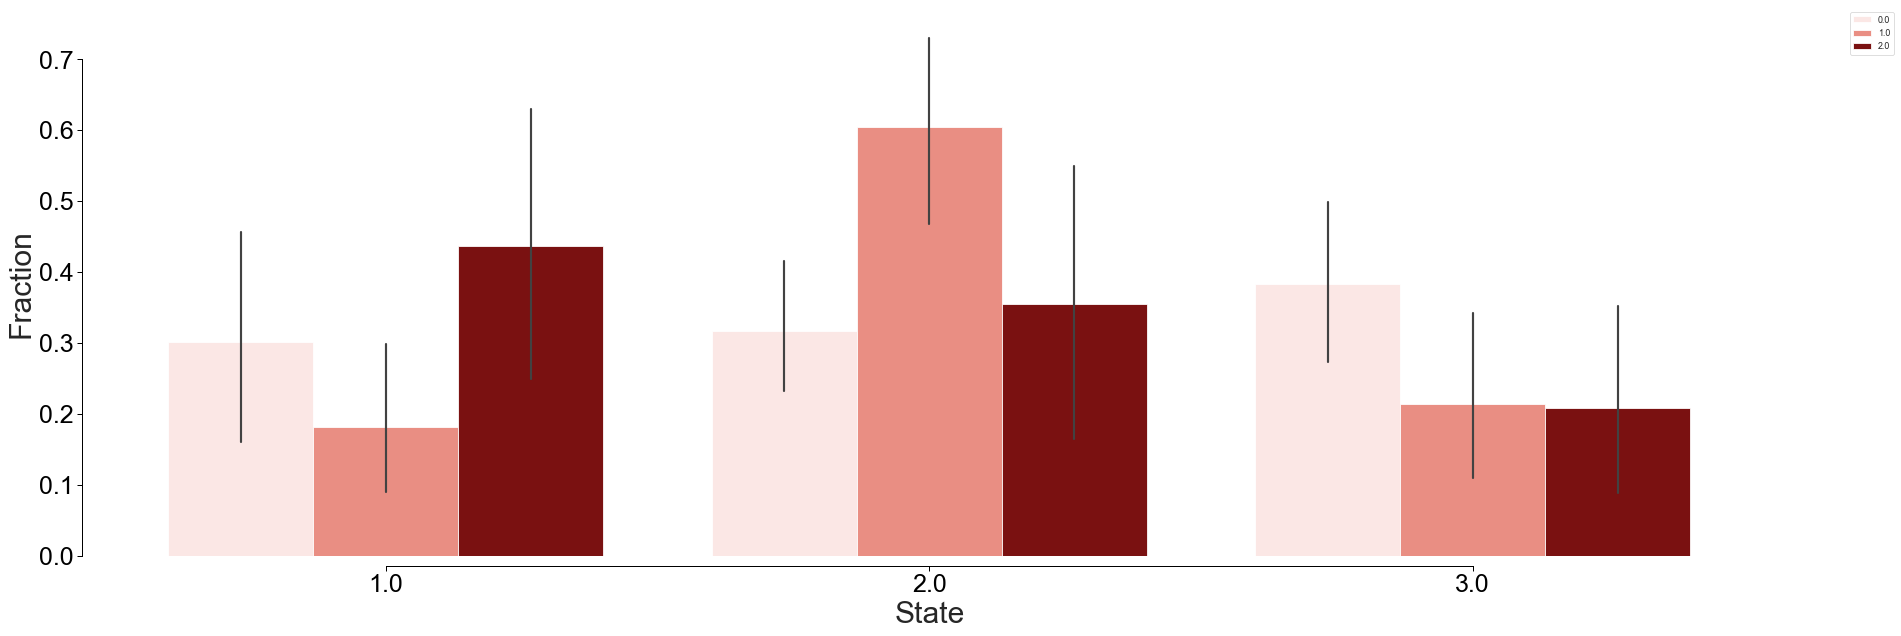

In [18]:
fraction_fig = pd.concat([fraction["State_1"], fraction["State_2"], fraction["State_3"]], axis=0)
fraction_fig = pd.DataFrame(fraction_fig)
fraction_fig.index = range(0,n_subjects*3)
fraction_fig = fraction_fig.rename(index=str, columns={0: "Fraction"})
fraction_fig["State"] = np.concatenate([np.ones(n_subjects), np.full(n_subjects,2),np.full(n_subjects,3)])
fraction_fig["Patient_status"] = np.concatenate([np.zeros(n_controls),subgroups,np.zeros(n_controls), subgroups, np.zeros(n_controls),subgroups])

plt.figure(figsize=(30, 10))
#sns.set(style="ticks", palette="pastel")   
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

sns.set_context("paper", rc={"font.size":30,"axes.titlesize":30,"axes.labelsize":30}) 

# Draw a nested boxplot to show bills by day and time
sns.barplot(x="State", y="Fraction",
            hue="Patient_status",palette=["mistyrose", "salmon", "darkred"],
            #hue="Patient_status",kind="bar",  palette=["silver", "salmon", "darkred"],
            data=fraction_fig)



sns.despine(offset=10, trim=True)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot()
#plt.savefig("Figures/ANOVA_Fraction_barplot_ci_0708.jpg", dpi=600)


In [19]:
# Three-level one-way ANOVA for fraction times 
a = stats.f_oneway(fraction["State_1"].loc[0:n_controls_1], fraction["State_1"].iloc[better],fraction["State_1"].iloc[worse],)[1]
b = stats.f_oneway(fraction["State_2"].loc[0:n_controls_1], fraction["State_2"].iloc[better],fraction["State_2"].iloc[worse],)[1]
c = stats.f_oneway(fraction["State_3"].loc[0:n_controls_1], fraction["State_3"].iloc[better],fraction["State_3"].iloc[worse],)[1]
print("State 1: %f" %stats.f_oneway(fraction["State_1"].loc[0:n_controls_1], fraction["State_1"].iloc[better],fraction["State_1"].iloc[worse],)[1])
print("State 2: %f" %stats.f_oneway(fraction["State_2"].loc[0:n_controls_1], fraction["State_2"].iloc[better],fraction["State_2"].iloc[worse],)[1])
print("State 3: %f" %stats.f_oneway(fraction["State_3"].loc[0:n_controls_1], fraction["State_3"].iloc[better],fraction["State_3"].iloc[worse],)[1])

State 1: 0.089971
State 2: 0.012044
State 3: 0.102539


In [20]:
# post-hoc t-test Control vs moderate
n_dfnc = ["State_1", "State_2", "State_3"]
no = [0,1,2,]
p_all_better = np.zeros(3)
print("Fraction time: Controls vs Patients with fewer symptoms")
for n, p in zip(n_dfnc, no):
    rvs1 = fraction[n].loc[0:n_controls_1]
    rvs2 = fraction[n].iloc[better]
    p_all_better[p] = stats.ttest_ind(rvs1,rvs2)[1] 
    print("%s" % n)
    print("Deficit: %f" %(rvs2.mean()))
    print("No Deficit: %f" %(rvs1.mean()))
    print("%f" %stats.ttest_ind(rvs1,rvs2)[1])

Fraction time: Controls vs Patients with fewer symptoms
State_1
Deficit: 0.182041
No Deficit: 0.300777
0.225499
State_2
Deficit: 0.604472
No Deficit: 0.316315
0.002814
State_3
Deficit: 0.213487
No Deficit: 0.382908
0.059323


In [21]:
# post-hoc t-test Control vs severe
p_all_worse = np.zeros(3)
print("Fraction time: Controls vs Patients with more symptoms")
for n, p in zip(n_dfnc, no):
    rvs1 = fraction[n].loc[0:n_controls_1]
    rvs2 = fraction[n].iloc[worse]
    p_all_worse[p] = stats.ttest_ind(rvs1,rvs2)[1] 
    print("%s" % n)
    print("Deficit: %f" %(rvs2.mean()))
    print("No Deficit: %f" %(rvs1.mean()))
    print("%f" %stats.ttest_ind(rvs1,rvs2)[1])

Fraction time: Controls vs Patients with more symptoms
State_1
Deficit: 0.436865
No Deficit: 0.300777
0.293216
State_2
Deficit: 0.354620
No Deficit: 0.316315
0.718227
State_3
Deficit: 0.208515
No Deficit: 0.382908
0.080028


In [22]:
# post-hoc t-test Moderate vs severe
p_all_bw = np.zeros(3)
print("Fraction time: Patients with moderate vs Patients with severe symptoms")
for n, p in zip(n_dfnc, no):
    rvs1 = fraction[n].iloc[better]
    rvs2 = fraction[n].iloc[worse]
    p_all_bw[p] = stats.ttest_ind(rvs1,rvs2)[1] 
    print("%s" % n)
    print("Severe Deficit: %f" %(rvs2.mean()))
    print("Moderate Deficit: %f" %(rvs1.mean()))
    print("%f" %stats.ttest_ind(rvs1,rvs2)[1])

Fraction time: Patients with moderate vs Patients with severe symptoms
State_1
Severe Deficit: 0.436865
Moderate Deficit: 0.182041
0.029460
State_2
Severe Deficit: 0.354620
Moderate Deficit: 0.604472
0.046787
State_3
Severe Deficit: 0.208515
Moderate Deficit: 0.213487
0.958815


In [23]:
# Correction for multiple comparison State 2
statsmodels.stats.multitest.multipletests([0.002814,0.718227, 0.046787], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)


(array([ True, False, False]),
 array([0.008442 , 0.718227 , 0.0701805]),
 0.016952427508441503,
 0.016666666666666666)

In [24]:
# load dwell times
dwell = loadmat('dwell_time.mat')["dwell"]
dwell = pd.DataFrame(dwell)
dwell.columns = ["State_1", "State_2", "State_3"]

In [25]:
rvs1 = np.array(dwell.loc[0:n_controls_1]).ravel()
rvs2 = np.array(dwell.iloc[better]).ravel()
rvs3 = np.array(dwell.iloc[worse]).ravel()
print("Mean dwell time")
print("No deficit: %f" %(rvs1.mean()))
print("Moderate Deficit: %f" %(rvs2.mean()))
print("Severe Deficit: %f" %(rvs3.mean()))
print("Mean dwell time diff: %f" %stats.f_oneway(rvs1, rvs2,rvs3,)[1])

Mean dwell time
No deficit: 19.800000
Moderate Deficit: 21.794753
Severe Deficit: 22.702137
Mean dwell time diff: 0.876693


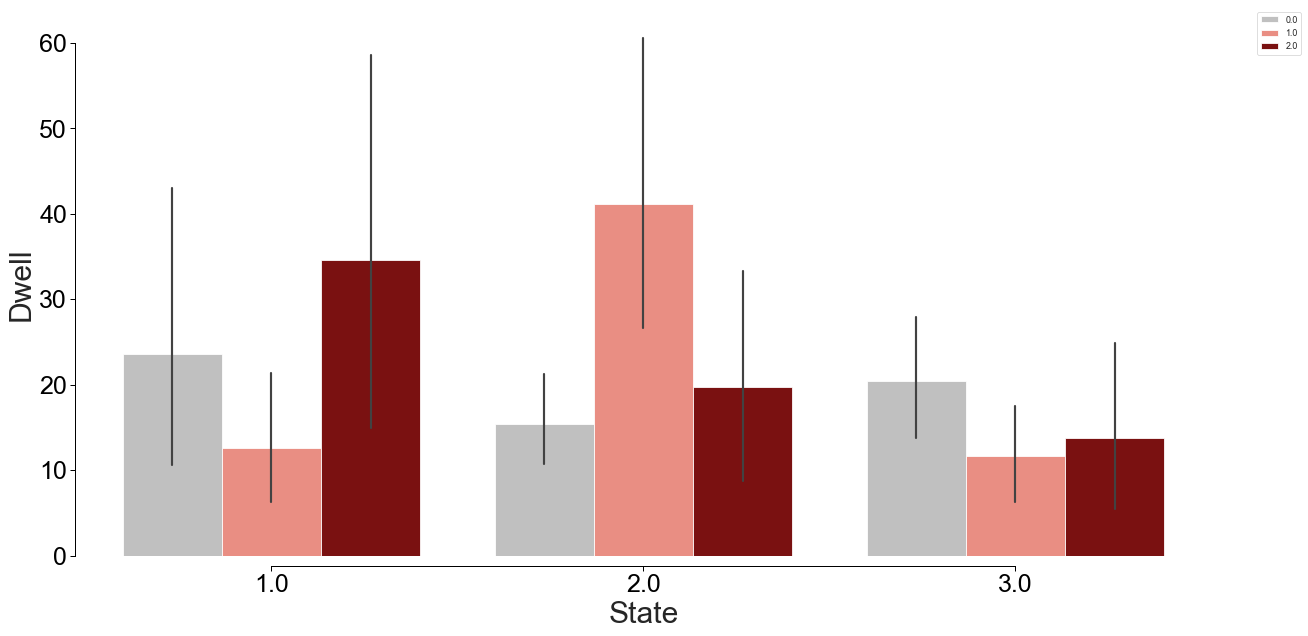

In [26]:
fraction_fig = pd.concat([dwell["State_1"], dwell["State_2"], dwell["State_3"]], axis=0)
fraction_fig = pd.DataFrame(fraction_fig)
fraction_fig.index = range(0,n_subjects*3)
fraction_fig = fraction_fig.rename(index=str, columns={0: "Dwell"})
fraction_fig["State"] = np.concatenate([np.ones(n_subjects), np.full(n_subjects,2),np.full(n_subjects,3)])
fraction_fig["Patient_status"] = np.concatenate([np.zeros(n_controls),subgroups,np.zeros(n_controls), subgroups, np.zeros(n_controls),subgroups])

plt.figure(figsize=(20, 10))
#sns.set(style="ticks", palette="pastel")   
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

sns.set_context("paper", rc={"font.size":30,"axes.titlesize":30,"axes.labelsize":30}) 

# Draw a nested boxplot to show bills by day and time
sns.barplot(x="State", y="Dwell",
            #hue="Patient_status",palette=["mistyrose", "salmon", "darkred"],
            hue="Patient_status",palette=["silver", "salmon", "darkred"],
            data=fraction_fig)
sns.despine(offset=10, trim=True)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("Figures/ANOVA_Dwell_silverreds_white_barplot_ci_0708", dpi=600)



In [27]:
# Three-level one-way ANOVA for fraction times 
d = stats.f_oneway(dwell["State_1"].loc[0:n_controls_1], dwell["State_1"].iloc[better],dwell["State_1"].iloc[worse],)[1]
e = stats.f_oneway(dwell["State_2"].loc[0:n_controls_1], dwell["State_2"].iloc[better],dwell["State_2"].iloc[worse],)[1]
f = stats.f_oneway(dwell["State_3"].loc[0:n_controls_1], dwell["State_3"].iloc[better],dwell["State_3"].iloc[worse],)[1]
print("State 1: %f" %stats.f_oneway(dwell["State_1"].loc[0:n_controls_1], dwell["State_1"].iloc[better],dwell["State_1"].iloc[worse],)[1])
print("State 2: %f" %stats.f_oneway(dwell["State_2"].loc[0:n_controls_1], dwell["State_2"].iloc[better],dwell["State_2"].iloc[worse],)[1])
print("State 3: %f" %stats.f_oneway(dwell["State_3"].loc[0:n_controls_1], dwell["State_3"].iloc[better],dwell["State_3"].iloc[worse],)[1])

State 1: 0.210229
State 2: 0.017806
State 3: 0.235434


In [28]:
# post-hoc t-test Control vs moderate
p_all_better = np.zeros(3)
print("Dwell time: Controls vs Patients with fewer symptoms")
for n, p in zip(n_dfnc, no):
    rvs1 = dwell[n].loc[0:n_controls_1]
    rvs2 = dwell[n].iloc[better]
    p_all_better[p] = stats.ttest_ind(rvs1,rvs2)[1] 
    print("%s" % n)
    print("Deficit: %f" %(rvs2.mean()))
    print("No Deficit: %f" %(rvs1.mean()))
    print("%f" %stats.ttest_ind(rvs1,rvs2)[1])

Dwell time: Controls vs Patients with fewer symptoms
State_1
Deficit: 12.603704
No Deficit: 23.544118
0.270897
State_2
Deficit: 41.148148
No Deficit: 15.435294
0.011187
State_3
Deficit: 11.632407
No Deficit: 20.420588
0.072571


In [29]:
# post-hoc t-test Control vs severe
p_all_worse = np.zeros(3)
print("Dwell time: Controls vs Patients with more symptoms")
for n, p in zip(n_dfnc, no):
    rvs1 = dwell[n].loc[0:n_controls_1]
    rvs2 = dwell[n].iloc[worse]
    p_all_worse[p] = stats.ttest_ind(rvs1,rvs2)[1] 
    print("%s" % n)
    print("Deficit: %f" %(rvs2.mean()))
    print("No Deficit: %f" %(rvs1.mean()))
    print("%f" %stats.ttest_ind(rvs1,rvs2)[1])

Dwell time: Controls vs Patients with more symptoms
State_1
Deficit: 34.647436
No Deficit: 23.544118
0.466551
State_2
Deficit: 19.676923
No Deficit: 15.435294
0.524411
State_3
Deficit: 13.782051
No Deficit: 20.420588
0.301595


In [30]:
# post-hoc t-test moderate vs severe
p_all_bw = np.zeros(3)
print("Dwell time: Controls vs Patients with more symptoms")
for n, p in zip(n_dfnc, no):
    rvs1 = dwell[n].loc[better]
    rvs2 = dwell[n].iloc[worse]
    p_all_bw[p] = stats.ttest_ind(rvs1,rvs2)[1] 
    print("%s" % n)
    print("Deficit: %f" %(rvs2.mean()))
    print("No Deficit: %f" %(rvs1.mean()))
    print("%f" %stats.ttest_ind(rvs1,rvs2)[1])

Dwell time: Controls vs Patients with more symptoms
State_1
Deficit: 34.647436
No Deficit: 12.603704
0.064863
State_2
Deficit: 19.676923
No Deficit: 41.148148
0.083586
State_3
Deficit: 13.782051
No Deficit: 11.632407
0.705393


In [32]:
# Correction for multiple comparison:  Dwell times State 2
statsmodels.stats.multitest.multipletests([0.011187, 0.524411, 0.083586], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)


(array([ True, False, False]),
 array([0.033561, 0.524411, 0.125379]),
 0.016952427508441503,
 0.016666666666666666)

In [33]:
num_trans = loadmat('num_trans.mat')["num_trans"]
num_trans = pd.DataFrame(num_trans)
rvs1 = num_trans.loc[0:n_controls_1]
rvs2 = num_trans.iloc[better]
rvs3 = num_trans.iloc[worse]
print("Mean No of transitions")
print("No deficit: %f" %(rvs1.mean()))
print("Moderate Deficit: %f" %(rvs2.mean()))
print("Severe Deficit: %f" %(rvs3.mean()))
print("Mean dwell time diff: %f" %stats.f_oneway(rvs1, rvs2,rvs3,)[1])

Mean No of transitions
No deficit: 7.058824
Moderate Deficit: 5.333333
Severe Deficit: 5.384615
Mean dwell time diff: 0.271068


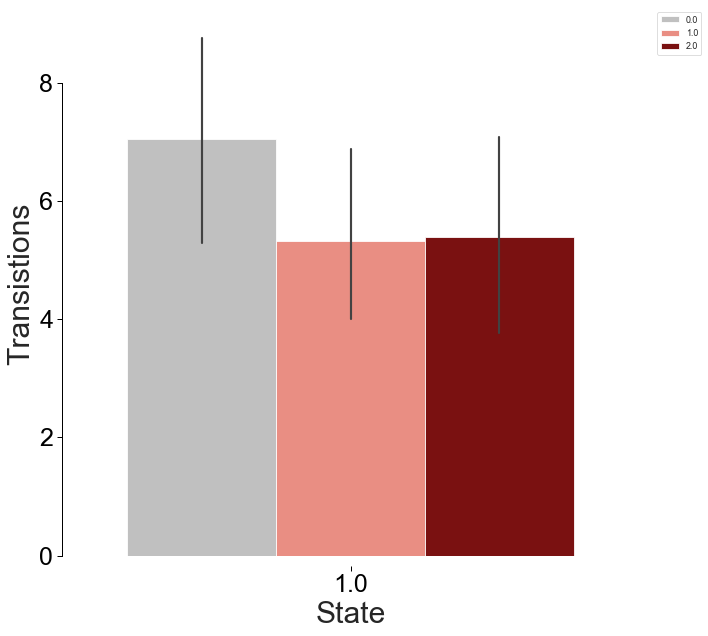

In [26]:
fraction_fig = pd.DataFrame(num_trans)
fraction_fig = fraction_fig.rename(index=str, columns={0: "Transistions"})
fraction_fig["State"] = np.concatenate([np.ones(n_subjects),])
fraction_fig["Patient_status"] = np.concatenate([np.zeros(n_controls),subgroups,])

plt.figure(figsize=(10, 10))
#sns.set(style="ticks", palette="pastel")   
sns.set_style('ticks', {'axes.edgecolor': '0',  
                        'xtick.color': '0',
                        'ytick.color': '0'})

sns.set_context("paper", rc={"font.size":30,"axes.titlesize":30,"axes.labelsize":30}) 

# Draw a nested boxplot to show bills by day and time
sns.barplot(x="State", y="Transistions",
            #hue="Patient_status",palette=["mistyrose", "salmon", "darkred"],
            hue="Patient_status",palette=["silver", "salmon", "darkred"],
            data=fraction_fig)
sns.despine(offset=10, trim=True)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("Figures/Transistions_silverreds_white_barplot_ci_0708", dpi=600)



In [34]:
# load transition likelihood
transition = loadmat('transition.mat')["transition"]

In [35]:
# Three-level one-way ANOVA transition likelihoods (from state, to state)
trans_p = []
for no_1 in range(0,3,1):
    for no_2 in range(0,3,1):
        trans_c = []
        trans_pb = []
        trans_pw = []
        for n in range(0,n_controls,1):
                trans_c.append(pd.DataFrame(transition[n]).loc[no_1,no_2])
        for n in better:
                trans_pb.append(pd.DataFrame(transition[n]).loc[no_1,no_2])
        for n in worse:
                trans_pw.append(pd.DataFrame(transition[n]).loc[no_1,no_2])
        print(no_1)
        print(no_2)
        trans_p.append(stats.f_oneway(np.array(trans_c), np.array(trans_pb),np.array(trans_pw))[1])
        print("Transition: %f" %stats.f_oneway(np.array(trans_c), np.array(trans_pb),np.array(trans_pw))[1])
              
              

0
0
Transition: 0.455326
0
1
Transition: 0.916524
0
2
Transition: 0.488049
1
0
Transition: 0.005966
1
1
Transition: 0.003268
1
2
Transition: 0.529718
2
0
Transition: 0.484782
2
1
Transition: 0.574085
2
2
Transition: 0.825900


In [36]:
# post-hoc t-test controls vs moderate
for no_1 in range(0,3,1):
    for no_2 in range(0,3,1):
        trans_c_11 = []
        trans_p_11 = []
        print(no_1)
        print(no_2)
        for n in range(0,n_controls,1):
                trans_c_11.append(pd.DataFrame(transition[n]).loc[no_1,no_2])
        print("Mean controls: %f" %np.array(trans_c_11).mean())
        for n in better:
                trans_p_11.append(pd.DataFrame(transition[n]).loc[no_1,no_2])
        print("Mean better: %f" %np.array(trans_p_11).mean())
        print("Stats %f" %stats.ttest_ind(np.array(trans_c_11),np.array(trans_p_11))[1]) 

0
0
Mean controls: 0.952437
Mean better: 0.929038
Stats 0.329327
0
1
Mean controls: 0.032590
Mean better: 0.034385
Stats 0.915928
0
2
Mean controls: 0.014973
Mean better: 0.036577
Stats 0.315380
1
0
Mean controls: 0.023230
Mean better: 0.011239
Stats 0.258894
1
1
Mean controls: 0.939024
Mean better: 0.969814
Stats 0.012250
1
2
Mean controls: 0.037746
Mean better: 0.018947
Stats 0.031005
2
0
Mean controls: 0.025422
Mean better: 0.014579
Stats 0.326101
2
1
Mean controls: 0.033016
Mean better: 0.056003
Stats 0.248106
2
2
Mean controls: 0.941562
Mean better: 0.929418
Stats 0.595056


In [37]:
# post-hoc t-test controls vs severe
for no_1 in range(0,3,1):
    for no_2 in range(0,3,1):
        trans_c_11 = []
        trans_p_11 = []
        print(no_1)
        print(no_2)
        for n in range(0,n_controls,1):
                trans_c_11.append(pd.DataFrame(transition[n]).loc[no_1,no_2])
        print("Mean controls: %f" %np.array(trans_c_11).mean())
        for n in worse:
                trans_p_11.append(pd.DataFrame(transition[n]).loc[no_1,no_2])
        print("Mean worse: %f" %np.array(trans_p_11).mean())
        print("%f" %stats.ttest_ind(np.array(trans_c_11),np.array(trans_p_11))[1]) 

0
0
Mean controls: 0.952437
Mean worse: 0.955012
0.891935
0
1
Mean controls: 0.032590
Mean worse: 0.027155
0.764524
0
2
Mean controls: 0.014973
Mean worse: 0.017833
0.788652
1
0
Mean controls: 0.023230
Mean worse: 0.099115
0.037698
1
1
Mean controls: 0.939024
Mean worse: 0.867102
0.056756
1
2
Mean controls: 0.037746
Mean worse: 0.033783
0.865955
2
0
Mean controls: 0.025422
Mean worse: 0.013575
0.335440
2
1
Mean controls: 0.033016
Mean worse: 0.065085
0.355443
2
2
Mean controls: 0.941562
Mean worse: 0.921340
0.573683


In [38]:
# post-hoc t-test moderate vs severe
for no_1 in range(0,3,1):
    for no_2 in range(0,3,1):
        trans_c_11 = []
        trans_p_11 = []
        print(no_1)
        print(no_2)
        for n in better:
                trans_c_11.append(pd.DataFrame(transition[n]).loc[no_1,no_2])
        print("Mean better: %f" %np.array(trans_c_11).mean())
        for n in worse:
                trans_p_11.append(pd.DataFrame(transition[n]).loc[no_1,no_2])
        print("Mean worse: %f" %np.array(trans_p_11).mean())
        print("%f" %stats.ttest_ind(np.array(trans_c_11),np.array(trans_p_11))[1]) 

0
0
Mean better: 0.929038
Mean worse: 0.955012
0.327436
0
1
Mean better: 0.034385
Mean worse: 0.027155
0.673724
0
2
Mean better: 0.036577
Mean worse: 0.017833
0.463219
1
0
Mean better: 0.011239
Mean worse: 0.099115
0.010861
1
1
Mean better: 0.969814
Mean worse: 0.867102
0.005151
1
2
Mean better: 0.018947
Mean worse: 0.033783
0.504697
2
0
Mean better: 0.014579
Mean worse: 0.013575
0.919773
2
1
Mean better: 0.056003
Mean worse: 0.065085
0.816883
2
2
Mean better: 0.929418
Mean worse: 0.921340
0.836126


In [39]:
# Correction for multiple comparisons: Transition 11
statsmodels.stats.multitest.multipletests([0.012250, 0.056756, 0.005151], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)


(array([ True, False,  True]),
 array([0.018375, 0.056756, 0.015453]),
 0.016952427508441503,
 0.016666666666666666)

In [40]:
# Correction for multiple comparisons:Transition 10
statsmodels.stats.multitest.multipletests([0.258894, 0.037698, 0.010861], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)


(array([False, False,  True]),
 array([0.258894, 0.056547, 0.032583]),
 0.016952427508441503,
 0.016666666666666666)

In [41]:
# Correction for multiple comparisons: Transition 11 & 10
statsmodels.stats.multitest.multipletests([0.012250, 0.056756, 0.005151, 0.258894, 0.037698, 0.010861], alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)


(array([ True, False,  True, False, False,  True]),
 array([0.0245   , 0.0681072, 0.0245   , 0.258894 , 0.056547 , 0.0245   ]),
 0.008512444610847103,
 0.008333333333333333)

In [43]:
trans_1_m = np.zeros((np.shape(better)[0],9))
trans_1_s = np.zeros((np.shape(worse)[0],9))
trans_1_c = np.zeros((n_controls,9))
trans_1_all = np.zeros((n_subjects,9))

for n in range(0,n_subjects,1):
        trans_1_all[n] = transition[n].ravel()
for n in range(0,n_controls,1):
        trans_1_c[n] = transition[n].ravel()
for n, no in zip(better, range(0,np.shape(better)[0])):
        trans_1_m[no] = transition[n].ravel()
for n, no in zip(worse, range(0,np.shape(worse)[0])):
        trans_1_s[no] = transition[n].ravel()
trans_1_m = pd.DataFrame(trans_1_m)
trans_1_s = pd.DataFrame(trans_1_s)
trans_1_c = pd.DataFrame(trans_1_c)
trans_1_all = pd.DataFrame(trans_1_all)

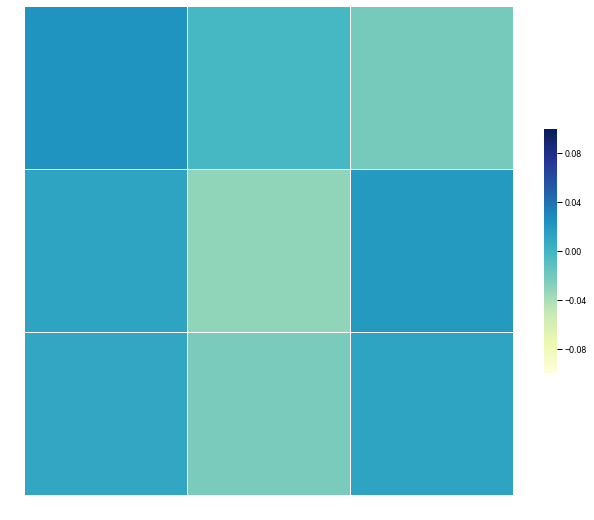

In [44]:
# Transition matrix: Controls vs Moderate
corr = np.array(trans_1_c.mean()-trans_1_m.mean()).reshape((3,3))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, cmap="YlGnBu", vmin=-0.1, vmax=0.1, 
           square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.axis('off')
plt.show()
#plt.savefig("Figures/Transistions_matrix_controls_moderate", dpi=600)

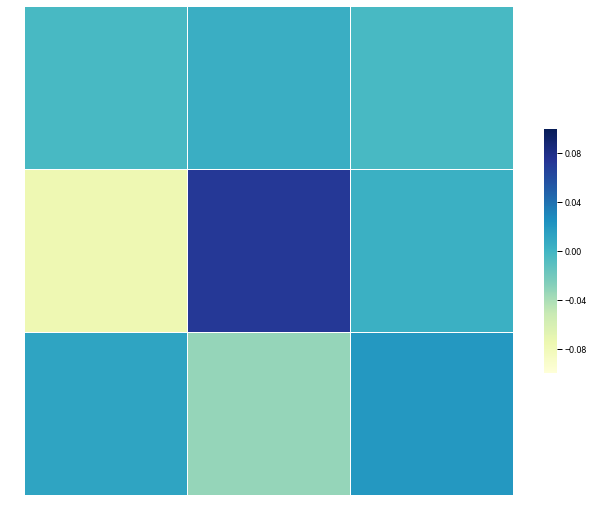

In [45]:
# Transition matrix: Controls vs Severe
corr = np.array(trans_1_c.mean()-trans_1_s.mean()).reshape((3,3))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, cmap="YlGnBu", vmin=-0.1, vmax=0.1, 
           square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.axis('off')
plt.show()
#plt.savefig("Figures/Transistions_matrix_controls_severe", dpi=600)

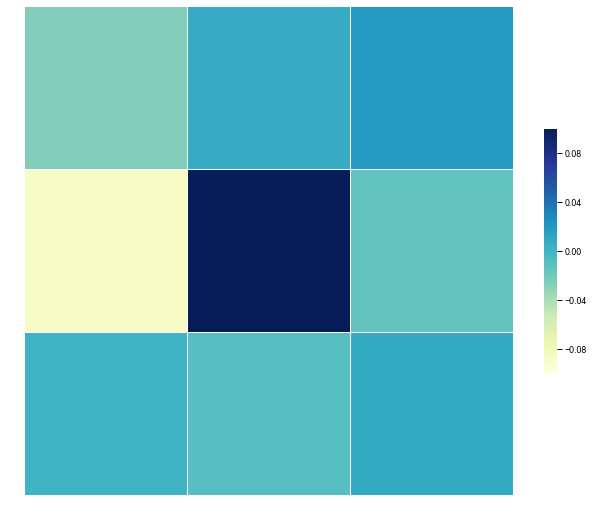

In [46]:
# Transition matrix: Moderate vs Severe
corr = np.array(trans_1_m.mean()-trans_1_s.mean()).reshape((3,3))
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, cmap="YlGnBu", vmin=-0.1, vmax=0.1, 
           square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.axis('off')
plt.show()
#plt.savefig("Figures/Transistions_matrix_moderate_severe", dpi=600)

In [47]:
# Creating state averages (MEDIAN) per subject
dfnc_1_med = pd.DataFrame(np.zeros((n_subjects, n_corr)))
dfnc_2_med = pd.DataFrame(np.zeros((n_subjects, n_corr)))
dfnc_3_med = pd.DataFrame(np.zeros((n_subjects, n_corr)))

for n in range(0,n_subjects,1):
        dfnc_1_med.loc[n] = np.array(pd.DataFrame(dfnc[n][states.loc[n]==1]).median(axis=0))
        #dfnc_1_med.loc[n] = np.array(pd.DataFrame(dfnc[n][states.loc[n]==1]).mean(axis=0))
        dfnc_1_med = pd.DataFrame(dfnc_1_med)
        dfnc_2_med.loc[n] = np.array(pd.DataFrame(dfnc[n][states.loc[n]==2]).median(axis=0))
        #dfnc_2_med.loc[n] = np.array(pd.DataFrame(dfnc[n][states.loc[n]==2]).mean(axis=0))
        dfnc_2_med = pd.DataFrame(dfnc_2_med)
        dfnc_3_med.loc[n] = np.array(pd.DataFrame(dfnc[n][states.loc[n]==3]).median(axis=0))
        #dfnc_3_med.loc[n] = np.array(pd.DataFrame(dfnc[n][states.loc[n]==3]).mean(axis=0))
        dfnc_3_med = pd.DataFrame(dfnc_3_med)

In [48]:
# One-way ANOVAS: State 1
p_all_ANOVA_1 = []
for n in range(0,np.shape(dfnc_1_med)[1]):
    p_all_ANOVA_1.append(stats.f_oneway(dfnc_1_med.loc[0:n_controls_1].dropna().loc[:, n], dfnc_1_med.loc[better].dropna().loc[:, n], dfnc_1_med.loc[worse].dropna().loc[:, n])[1])
# One-way ANOVAS: State 2
p_all_ANOVA_2 = []
for n in range(0,np.shape(dfnc_2_med)[1]):
    p_all_ANOVA_2.append(stats.f_oneway(dfnc_2_med.loc[0:n_controls_1].dropna().loc[:, n], dfnc_2_med.loc[better].dropna().loc[:, n], dfnc_2_med.loc[worse].dropna().loc[:, n])[1])
# One-way ANOVAS: State 2
p_all_ANOVA_3 = []
for n in range(0,np.shape(dfnc_3_med)[1]):
    p_all_ANOVA_3.append(stats.f_oneway(dfnc_3_med.loc[0:n_controls_1].dropna().loc[:, n], dfnc_3_med.loc[better].dropna().loc[:, n], dfnc_3_med.loc[worse].dropna().loc[:, n])[1])


In [49]:
uncorrected_ANOVA_1 = pd.DataFrame(return_dfnc_from_vector(p_all_ANOVA_1))
#uncorrected_ANOVA_1

In [50]:
uncorrected_ANOVA_2 = pd.DataFrame(return_dfnc_from_vector(p_all_ANOVA_2))
#uncorrected_ANOVA_2

In [51]:
uncorrected_ANOVA_3 = pd.DataFrame(return_dfnc_from_vector(p_all_ANOVA_3))
#uncorrected_ANOVA_3

In [52]:
# T-test: Controls vs Better
# State 1
p_all_t_better_1 = []
for n in range(0,np.shape(dfnc_1_med)[1]):
    p_all_t_better_1.append(stats.ttest_ind(dfnc_1_med.loc[0:n_controls_1].dropna().loc[:, n], dfnc_1_med.loc[better].dropna().loc[:, n],)[1])
# State 2
p_all_t_better_2 = []
for n in range(0,np.shape(dfnc_2_med)[1]):
    p_all_t_better_2.append(stats.ttest_ind(dfnc_2_med.loc[0:n_controls_1].dropna().loc[:, n], dfnc_2_med.loc[better].dropna().loc[:, n], )[1])
# State 2
p_all_t_better_3 = []
for n in range(0,np.shape(dfnc_3_med)[1]):
    p_all_t_better_3.append(stats.ttest_ind(dfnc_3_med.loc[0:n_controls_1].dropna().loc[:, n], dfnc_3_med.loc[better].dropna().loc[:, n], )[1])


In [53]:
uncorrected_t_better_1 = pd.DataFrame(return_dfnc_from_vector(p_all_t_better_1))
#uncorrected_t_better_1

In [54]:
uncorrected_t_better_2 = pd.DataFrame(return_dfnc_from_vector(p_all_t_better_2))
#uncorrected_t_better_2

In [55]:
uncorrected_t_better_3 = pd.DataFrame(return_dfnc_from_vector(p_all_t_better_3))
#uncorrected_t_better_3

In [56]:
# T-test: Controls vs Worse
# State 1
p_all_t_worse_1 = []
for n in range(0,np.shape(dfnc_1_med)[1]):
    p_all_t_worse_1.append(stats.ttest_ind(dfnc_1_med.loc[0:n_controls_1].dropna().loc[:, n], dfnc_1_med.loc[worse].dropna().loc[:, n],)[1])
# State 2
p_all_t_worse_2 = []
for n in range(0,np.shape(dfnc_2_med)[1]):
    p_all_t_worse_2.append(stats.ttest_ind(dfnc_2_med.loc[0:n_controls_1].dropna().loc[:, n], dfnc_2_med.loc[worse].dropna().loc[:, n], )[1])
# State 2
p_all_t_worse_3 = []
for n in range(0,np.shape(dfnc_3_med)[1]):
    p_all_t_worse_3.append(stats.ttest_ind(dfnc_3_med.loc[0:n_controls_1].dropna().loc[:, n], dfnc_3_med.loc[worse].dropna().loc[:, n], )[1])


In [57]:
uncorrected_t_worse_1 = pd.DataFrame(return_dfnc_from_vector(p_all_t_worse_1))
#uncorrected_t_worse_1

In [58]:
uncorrected_t_worse_2 = pd.DataFrame(return_dfnc_from_vector(p_all_t_worse_2))
#uncorrected_t_worse_2

In [59]:
uncorrected_t_worse_3 = pd.DataFrame(return_dfnc_from_vector(p_all_t_worse_3))
#uncorrected_t_worse_3

In [60]:
# T-test: Better vs Worse
# State 1
p_all_t_bw_1 = []
for n in range(0,np.shape(dfnc_1_med)[1]):
    p_all_t_bw_1.append(stats.ttest_ind(dfnc_1_med.loc[better].dropna().loc[:, n], dfnc_1_med.loc[worse].dropna().loc[:, n],)[1])
# State 2
p_all_t_bw_2 = []
for n in range(0,np.shape(dfnc_2_med)[1]):
    p_all_t_bw_2.append(stats.ttest_ind(dfnc_2_med.loc[better].dropna().loc[:, n], dfnc_2_med.loc[worse].dropna().loc[:, n], )[1])
# State 2
p_all_t_bw_3 = []
for n in range(0,np.shape(dfnc_3_med)[1]):
    p_all_t_bw_3.append(stats.ttest_ind(dfnc_3_med.loc[better].dropna().loc[:, n], dfnc_3_med.loc[worse].dropna().loc[:, n], )[1])


In [61]:
uncorrected_t_bw_1 = pd.DataFrame(return_dfnc_from_vector(p_all_t_bw_1))
#uncorrected_t_bw_1

In [62]:
uncorrected_t_bw_2 = pd.DataFrame(return_dfnc_from_vector(p_all_t_bw_2))
#uncorrected_t_bw_2

In [63]:
uncorrected_t_bw_3 = pd.DataFrame(return_dfnc_from_vector(p_all_t_bw_3))
#uncorrected_t_bw_3

In [64]:
# State 1
mask = np.zeros_like(uncorrected_t_better_3*(uncorrected_ANOVA_3<0.05), dtype=np.bool)
mask[np.tril_indices_from(mask)] = True


bw_p_1 = uncorrected_t_bw_1*(uncorrected_ANOVA_1<0.05)*mask
bw_p_1 = np.ravel(bw_p_1[bw_p_1!=0])
bw_p_1 = bw_p_1[~np.isnan(bw_p_1)]
better_p_1 = uncorrected_t_better_1*(uncorrected_ANOVA_1<0.05)*mask
better_p_1 = np.ravel(better_p_1[better_p_1!=0])
better_p_1 = better_p_1[~np.isnan(better_p_1)]
worse_p_1 = uncorrected_t_worse_1*(uncorrected_ANOVA_1<0.05)*mask
worse_p_1 = np.ravel(worse_p_1[worse_p_1!=0])
worse_p_1 = worse_p_1[~np.isnan(worse_p_1)]

In [65]:
statsmodels.stats.multitest.multipletests(np.concatenate((better_p_1, worse_p_1, bw_p_1,)), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)


(array([False, False, False, False, False, False]),
 array([0.06817093, 0.06817093, 0.22517745, 0.07661444, 0.22517745,
        0.22517745]),
 0.008512444610847103,
 0.008333333333333333)

In [66]:
# State 2
bw_p_2 = uncorrected_t_bw_2*(uncorrected_ANOVA_2<0.05)*mask
bw_p_2 = np.ravel(bw_p_2[bw_p_2!=0])
bw_p_2 = bw_p_2[~np.isnan(bw_p_2)]
better_p_2 = uncorrected_t_better_2*(uncorrected_ANOVA_2<0.05)*mask
better_p_2 = np.ravel(better_p_2[better_p_2!=0])
better_p_2 = better_p_2[~np.isnan(better_p_2)]
worse_p_2 = uncorrected_t_worse_2*(uncorrected_ANOVA_2<0.05)*mask
worse_p_2 = np.ravel(worse_p_2[worse_p_2!=0])
worse_p_2 = worse_p_2[~np.isnan(worse_p_2)]

In [67]:
statsmodels.stats.multitest.multipletests(np.concatenate((better_p_2, worse_p_2, bw_p_2,)), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)


(array([ True, False, False]),
 array([0.03299647, 0.61371339, 0.06222472]),
 0.016952427508441503,
 0.016666666666666666)

In [68]:
# State 3
bw_p_3 = uncorrected_t_bw_3*(uncorrected_ANOVA_3<0.05)*mask
bw_p_3 = np.ravel(bw_p_3[bw_p_3!=0])
bw_p_3 = bw_p_3[~np.isnan(bw_p_3)]
better_p_3 = uncorrected_t_better_3*(uncorrected_ANOVA_3<0.05)*mask
better_p_3 = np.ravel(better_p_3[better_p_3!=0])
better_p_3 = better_p_3[~np.isnan(better_p_3)]
worse_p_3 = uncorrected_t_worse_3*(uncorrected_ANOVA_3<0.05)*mask
worse_p_3 = np.ravel(worse_p_3[worse_p_3!=0])
worse_p_3 = worse_p_3[~np.isnan(worse_p_3)]

In [69]:
statsmodels.stats.multitest.multipletests(np.concatenate((better_p_3, worse_p_3, bw_p_3,)), alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

(array([ True,  True, False,  True, False,  True, False, False, False,
        False,  True, False, False, False,  True,  True, False, False,
        False, False,  True,  True, False,  True]),
 array([0.03023509, 0.00886416, 0.10957657, 0.03023509, 0.09265899,
        0.03023509, 0.76620303, 0.99668859, 0.24167027, 0.27346445,
        0.03023509, 0.89710598, 0.25570924, 0.46644105, 0.03023509,
        0.00886416, 0.5715549 , 0.46644105, 0.58155435, 0.10957657,
        0.02204518, 0.03023509, 0.06123331, 0.03023509]),
 0.002134938369701578,
 0.0020833333333333333)

In [73]:
# absolute connectivities
connectivity_diff_1_better = pd.DataFrame(return_dfnc_from_vector(np.absolute(dfnc_1_med.loc[better].dropna().median(axis=0))-np.absolute(dfnc_1_med.loc[0:n_controls_1].dropna().median(axis=0))))
connectivity_diff_2_better = pd.DataFrame(return_dfnc_from_vector(np.absolute(dfnc_2_med.loc[better].dropna().median(axis=0))-np.absolute(dfnc_2_med.loc[0:n_controls_1].dropna().median(axis=0))))
connectivity_diff_3_better = pd.DataFrame(return_dfnc_from_vector(np.absolute(dfnc_3_med.loc[better].dropna().median(axis=0))-np.absolute(dfnc_3_med.loc[0:n_controls_1].dropna().median(axis=0))))
connectivity_diff_1_worse = pd.DataFrame(return_dfnc_from_vector(np.absolute(dfnc_1_med.loc[worse].dropna().median(axis=0))-np.absolute(dfnc_1_med.loc[0:n_controls_1].dropna().median(axis=0))))
connectivity_diff_2_worse = pd.DataFrame(return_dfnc_from_vector(np.absolute(dfnc_2_med.loc[worse].dropna().median(axis=0))-np.absolute(dfnc_2_med.loc[0:n_controls_1].dropna().median(axis=0))))
connectivity_diff_3_worse = pd.DataFrame(return_dfnc_from_vector(np.absolute(dfnc_3_med.loc[worse].dropna().median(axis=0))-np.absolute(dfnc_3_med.loc[0:n_controls_1].dropna().median(axis=0))))
connectivity_diff_1_bw = pd.DataFrame(return_dfnc_from_vector(np.absolute(dfnc_1_med.loc[worse].dropna().median(axis=0))-np.absolute(dfnc_1_med.loc[better].dropna().median(axis=0))))
connectivity_diff_2_bw = pd.DataFrame(return_dfnc_from_vector(np.absolute(dfnc_2_med.loc[worse].dropna().median(axis=0))-np.absolute(dfnc_2_med.loc[better].dropna().median(axis=0))))
connectivity_diff_3_bw = pd.DataFrame(return_dfnc_from_vector(np.absolute(dfnc_3_med.loc[worse].dropna().median(axis=0))-np.absolute(dfnc_3_med.loc[better].dropna().median(axis=0))))



In [74]:
significant_connectivity_2_better = connectivity_diff_2_better*(uncorrected_t_better_2<0.012)
significant_connectivity_3_better = connectivity_diff_3_better*(uncorrected_t_better_3<0.013)
significant_connectivity_3_bw = connectivity_diff_3_bw*(uncorrected_t_bw_3<0.013)
significant_connectivity_3_worse = connectivity_diff_3_worse*(uncorrected_t_worse_3<0.013)

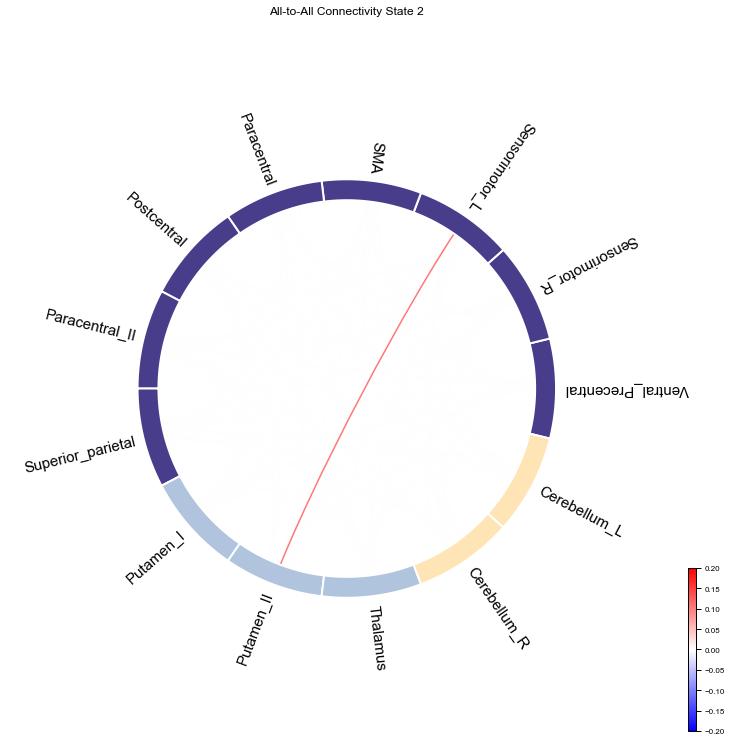

In [75]:
label_names = ["Ventral_Precentral","Sensorimotor_R","Sensorimotor_L","SMA","Paracentral","Postcentral","Paracentral_II","Superior_parietal","Putamen_I","Putamen_II","Thalamus","Cerebellum_R","Cerebellum_L",]
fig = plt.figure(num=None, figsize=(15, 15), facecolor='white')
node_colors = ["darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","lightsteelblue","lightsteelblue","lightsteelblue","moccasin","moccasin"]
plot_connectivity_circle(np.array(significant_connectivity_2_better), label_names, node_colors=node_colors,node_edgecolor="white",colormap="bwr",facecolor="white",textcolor="black", vmin=-0.2, vmax=0.2, n_lines=500, fontsize_names=15, title='All-to-All Connectivity State 2', fig=fig)
plt.show()
#fig.savefig("DFNC_sign_connectivity_2_better_2_0708.png", dpi=600)



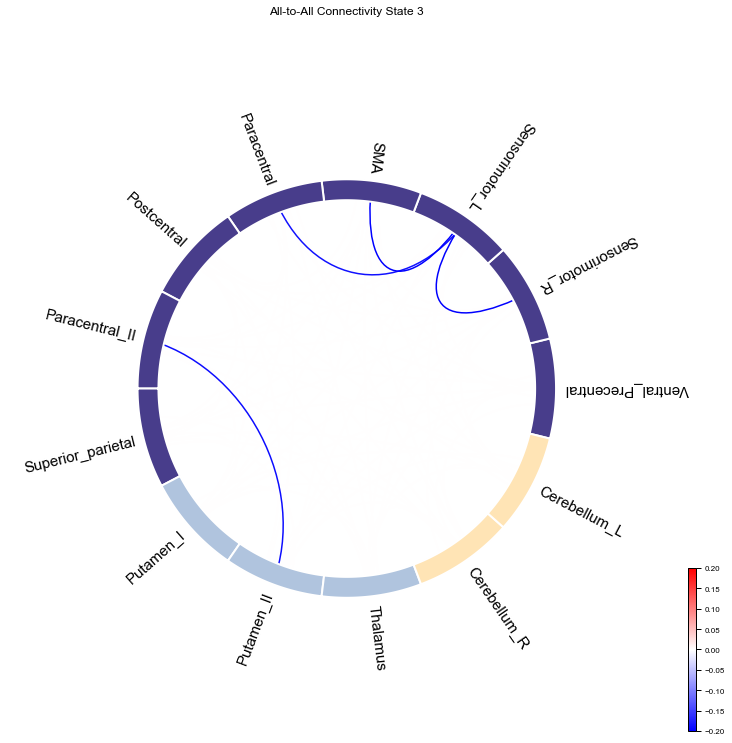

In [76]:
label_names = ["Ventral_Precentral","Sensorimotor_R","Sensorimotor_L","SMA","Paracentral","Postcentral","Paracentral_II","Superior_parietal","Putamen_I","Putamen_II","Thalamus","Cerebellum_R","Cerebellum_L",]
fig = plt.figure(num=None, figsize=(15, 15), facecolor='white')
node_colors = ["darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","lightsteelblue","lightsteelblue","lightsteelblue","moccasin","moccasin"]
plot_connectivity_circle(np.array(significant_connectivity_3_better), label_names, node_colors=node_colors,node_edgecolor="white",colormap="bwr",facecolor="white",textcolor="black", vmin=-0.2, vmax=0.2, n_lines=500, fontsize_names=15, title='All-to-All Connectivity State 3', fig=fig)
plt.show()
#fig.savefig("DFNC_sign_connectivity_3_better_2_0708.png", dpi=600)



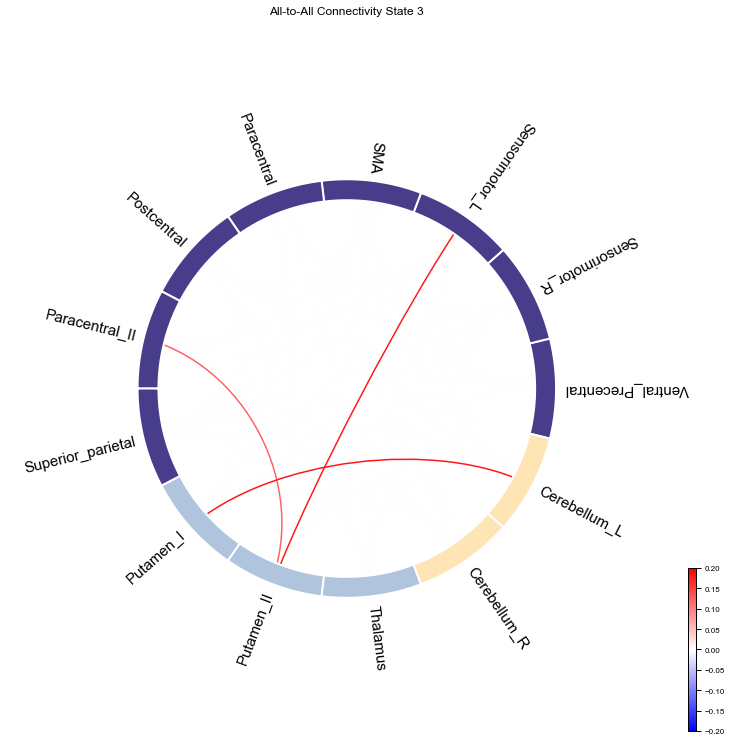

In [77]:
label_names = ["Ventral_Precentral","Sensorimotor_R","Sensorimotor_L","SMA","Paracentral","Postcentral","Paracentral_II","Superior_parietal","Putamen_I","Putamen_II","Thalamus","Cerebellum_R","Cerebellum_L",]
fig = plt.figure(num=None, figsize=(15, 15), facecolor='white')
node_colors = ["darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","lightsteelblue","lightsteelblue","lightsteelblue","moccasin","moccasin"]
plot_connectivity_circle(np.array(significant_connectivity_3_bw), label_names, node_colors=node_colors,node_edgecolor="white",colormap="bwr",facecolor="white",textcolor="black", vmin=-0.2, vmax=0.2, n_lines=500, fontsize_names=15, title='All-to-All Connectivity State 3', fig=fig)
plt.show()
#fig.savefig("DFNC_sign_connectivity_3_bw_2_0708.png", dpi=600)


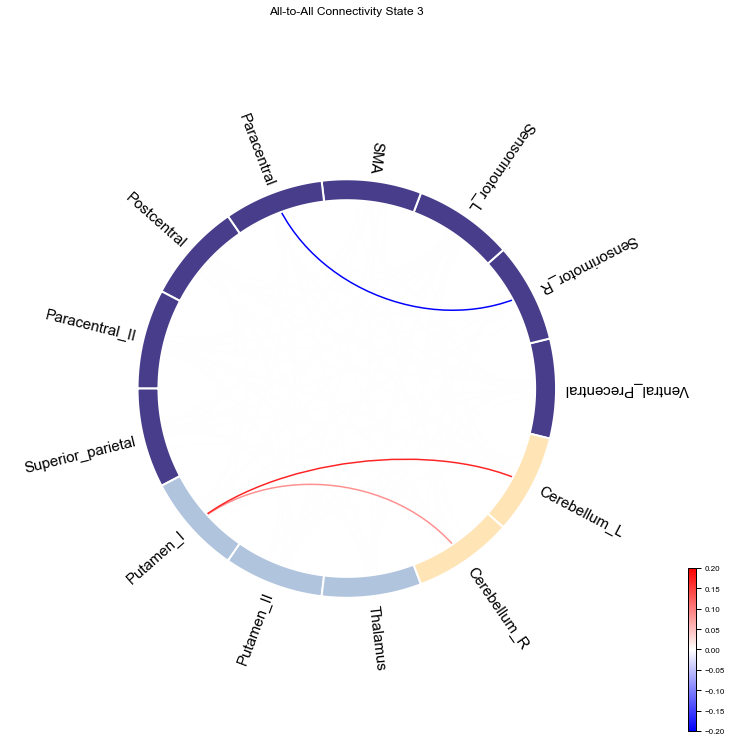

In [78]:
label_names = ["Ventral_Precentral","Sensorimotor_R","Sensorimotor_L","SMA","Paracentral","Postcentral","Paracentral_II","Superior_parietal","Putamen_I","Putamen_II","Thalamus","Cerebellum_R","Cerebellum_L",]
fig = plt.figure(num=None, figsize=(15, 15), facecolor='white')
node_colors = ["darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","darkslateblue","lightsteelblue","lightsteelblue","lightsteelblue","moccasin","moccasin"]
plot_connectivity_circle(np.array(significant_connectivity_3_worse), label_names, node_colors=node_colors,node_edgecolor="white",colormap="bwr",facecolor="white",textcolor="black", vmin=-0.2, vmax=0.2, n_lines=500, fontsize_names=15, title='All-to-All Connectivity State 3', fig=fig)
plt.show()
#fig.savefig("DFNC_sign_connectivity_3_worse_2_0708.png", dpi=600)


In [80]:
# Manhatten distance
sfnc = loadmat('sfnc_corrs.mat')["static"]
sfnc = pd.DataFrame(sfnc)
print("Distance state 1: %f " %(distance.cityblock(sfnc.median(), dfnc_1_med.dropna().median())))
print("Distance state 2: %f " %(distance.cityblock(sfnc.median(), dfnc_2_med.dropna().median())))
print("Distance state 3: %f " %(distance.cityblock(sfnc.median(), dfnc_3_med.dropna().median())))

Distance state 1: 8.484769 
Distance state 2: 12.712131 
Distance state 3: 10.626553 
